In [1]:
import numpy as np
import pandas as pd
import sima2py as sapy

In [2]:
#this is great, but I need to be able to get more events, that means analyzing/skimming multiple files
import re

#fileregex = re.compile('Run68_gdirect_bknd_R68_PuBe_0x0006_1M_155076\\S+.txt')
#dirpath,f = sapy.listFiles('/data/chocula/villaa/k100Sim_Data/captureCal/',fileregex)

In [3]:
#print(np.size(f))

# New Skim of this Data (w/ and w/o Captures)

I've now made two skims of the data with the following commands:

```./sima2py.py --regex 'Run68_gdirect_bknd_R68_PuBe_0x0006_10M_1550\S+.txt' --filedir /data/chocula/villaa/k100Sim_Data/captureCal/ --outfile /data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat_nocap.h5```

and 

```./sima2py.py --regex 'Run68_gdirect_bknd_R68_PuBe_0x0006_10M_1550\S+.txt' --filedir /data/chocula/villaa/k100Sim_Data/captureCal/ --outfile /data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat.h5```

<font color='red'>NOTE:</font> the above look like the same command but there are hard-coded cuts that were changed. The code used was in `villaa/analysis/cdms_simulation/k100_ncapture_cal/sima2py` and for the first command (added cut to remove captures) I used hash `ff2d90` and for the second I used hash `0f3915`


This created a file `/data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat.h5` and `/data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat_nocap.h5` which is a file with all the nuclear recoils and only the non-captures respectively. 

In [4]:
#play around with some hits data stored in h5 file
#===============to suppress h5py warning see:
#https://github.com/h5py/h5py/issues/961
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
f = h5py.File("/data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat.h5","r")

data = f['geant4/hits']

f_nocap = h5py.File("/data/chocula/villaa/k100Sim_Data/captureCalhdf5/R68_gdirect_testskim_superhighstat_nocap.h5","r")
    
data_nocap = f_nocap['geant4/hits']

In [5]:
#now make a dataframe with the restricted data
nr_data = data[:,[0,4,5,6,21]]
nr_dataframe = pd.DataFrame(data=nr_data)
nr_data_nocap = data_nocap[:,[0,4,5,6,21]]
nr_dataframe_nocap = pd.DataFrame(data=nr_data_nocap)

#print(nr_dataframe)

groupbyvec=[0]
#print(np.max(nr_dataframe.groupby([0,1],axis=0).size()))
max_vec = np.max(nr_dataframe.groupby(groupbyvec,axis=0).size())

evec = np.zeros((0,max_vec))
nhit = np.zeros((0,1))

for i in nr_dataframe.groupby(groupbyvec,axis=0)[3].apply(list):
    #print(i)
    #print(np.shape(i))
    vector = np.zeros((1,max_vec))
    #print(np.shape(vector[0,0:np.shape(i)[0]]))
    vector[0,0:np.shape(i)[0]] = np.transpose(np.asarray(i))
    evec = np.append(evec,vector*1e6,0) #convert from MeV
    nhit = np.append(nhit,np.shape(i)[0])
    
max_vec_nocap = np.max(nr_dataframe_nocap.groupby(groupbyvec,axis=0).size())

evec_nocap = np.zeros((0,max_vec_nocap))
nhit_nocap = np.zeros((0,1))

for i in nr_dataframe_nocap.groupby(groupbyvec,axis=0)[3].apply(list):
    #print(i)
    #print(np.shape(i))
    vector = np.zeros((1,max_vec_nocap))
    #print(np.shape(vector[0,0:np.shape(i)[0]]))
    vector[0,0:np.shape(i)[0]] = np.transpose(np.asarray(i))
    evec_nocap = np.append(evec_nocap,vector*1e6,0) #convert from MeV
    nhit_nocap = np.append(nhit_nocap,np.shape(i)[0])

In [6]:
import damic_y as dy 

#a spline extrapolation to DAMIC data
damic_y = dy.getDAMICy()
damic_yv = np.vectorize(damic_y) #vectorize it

dict_keys(['xx', 'yy', 'ex', 'ey'])


In [7]:
print(damic_y(2000))

0.1595234066959043


In [8]:
#convert evec to eVee
V = 120
eps = 3.8 #eV for silicon
F = 0.1161 #silicon value taken from https://www.sciencedirect.com/science/article/pii/S0168900297009650
evec_ee = (evec + evec*damic_y(evec)*(V/eps))/(1+(V/eps))
evec_ee_nocap = (evec_nocap + evec_nocap*damic_y(evec_nocap)*(V/eps))/(1+(V/eps))

In [9]:
#make some histograms

xmax = 1000
thresh = 7 #at best a 7 eV threshold
sume = np.sum(evec_ee,1)
n,nx = np.histogram(sume[sume>thresh],100,range=(0,xmax))
sume_nocap = np.sum(evec_ee_nocap,1)
n_nocap,nx_nocap = np.histogram(sume_nocap[sume_nocap>thresh],100,range=(0,xmax))
#n_ss,nx_ss = np.histogram(np.sum(nr_energies[nr_hits==1,:],1)*1000,250,range=(0,xmax))
#n_ms,nx_ms = np.histogram(np.sum(nr_energies[nr_hits>1,:],1)*1000,250,range=(0,xmax))




xc = (nx[:-1] + nx[1:]) / 2

In [10]:
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

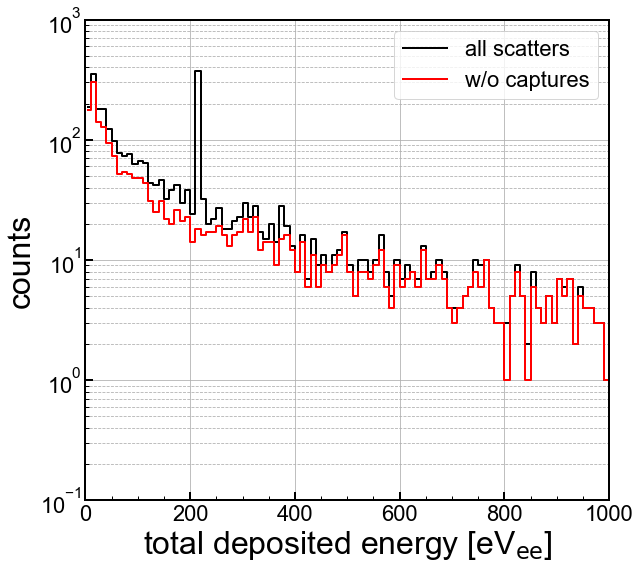

In [11]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

ymin=0.1
ymax=1000
ax1.step(xc,n, where='mid',color='k', linestyle='-', \
         label='all scatters', linewidth=2)
ax1.step(xc,n_nocap, where='mid',color='r', linestyle='-', \
         label='w/o captures', linewidth=2)




#tlabel = 'Thresh. {0} eV$_{{\mathrm{{ee}}}}$'.format(18)
#ax1.axvline(thresh, color='k', linestyle='--', lw=2, alpha=0.8,label=tlabel)
#erange_x = np.arange(thresh-sigthr, thresh+sigthr, 0.01)
#ax1.fill_between(erange_x, ymin, ymax, facecolor='r', alpha=0.3)

ax1.set_yscale('log')
ax1.set_xlim(0, xmax) #in pairs
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('total deposited energy [eV$_{\\mathrm{ee}}$]',**axis_font)
ax1.set_ylabel('counts',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/R68_gdirect_firstNRbknd_wwoCap_nores.png')
plt.show()

In [12]:
fpube = open('data/r68_n125_PuBe_PTOFkeV_1keV_spikesremoved_scan_fmt.txt')
fbknd = open('data/r68_n125_bkg_PTOFkeV_1keV_spikesremoved_scan_fmt.txt')
#fpube = open('data/r68_n125_PuBe_cgood_PTOFkeV0_1keV_scan_fmt.txt')
#fbknd = open('data/r68_n125_Bkg_cgood_PTOFkeV0_1keV_scan_fmt.txt')

d = np.asarray([x.split() for x in fpube.readlines()],dtype=np.float)
db = np.asarray([x.split() for x in fbknd.readlines()],dtype=np.float)

dE = d[:,0]
dbE = db[:,0]
print(np.shape(dE))
print(np.shape(dbE))

(352809,)
(157816,)


In [13]:
#get histogram
#emax = 500 #emax in eV
emax=1000
nbins = 100

nd_68,nxd_68 = np.histogram(dE*1000,nbins,range=(0,emax))

xcd_68 = (nxd_68[:-1] + nxd_68[1:]) / 2

ndb_68,nxdb_68 = np.histogram(dbE*1000,nbins,range=(0,emax))

xcdb_68 = (nxdb_68[:-1] + nxdb_68[1:]) / 2



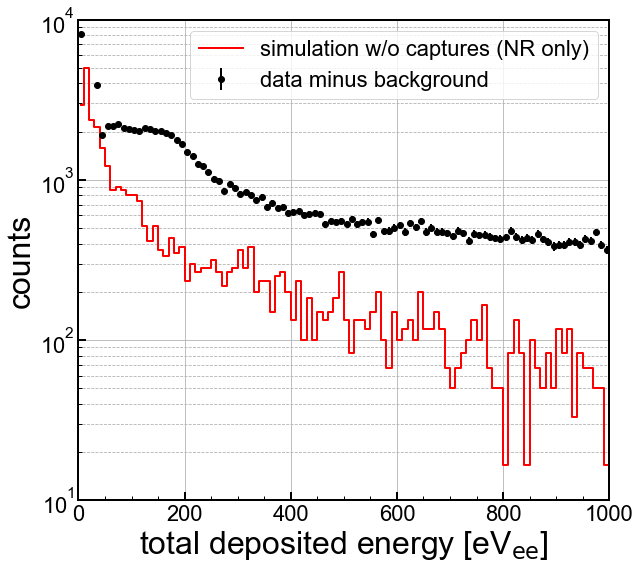

In [14]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

livefac = (60/3.6) #livetime fraction estimated from M. Fritts see email from March 22 2019.
#he estimates 60 live hours of data
#my simulation corresponds to 3.6 live hours if 1e6 neutrons/sec
#or 1.8 live hours if 2e6 neutrons/second Pu/Be source. 

ymin=10
ymax=10000
#ax1.step(xc,n*livefac, where='mid',color='k', linestyle='-', \
#         label='all scatters', linewidth=2)
ax1.step(xc,n_nocap*livefac, where='mid',color='r', linestyle='-', \
         label='simulation w/o captures (NR only)', linewidth=2)

dlabel='data minus background'
#step1, = ax1.step(xcd_68,nd_68-ndb_68, where='mid',color='k', linestyle='-', label=dlabel, linewidth=2)
err = np.sqrt(nd_68+ndb_68)
ax1.errorbar(xcd_68,nd_68-ndb_68,yerr=[err,err], marker='o', markersize=6, \
             ecolor='k',color='k', linestyle='none', label=dlabel, linewidth=2)




#tlabel = 'Thresh. {0} eV$_{{\mathrm{{ee}}}}$'.format(18)
#ax1.axvline(thresh, color='k', linestyle='--', lw=2, alpha=0.8,label=tlabel)
#erange_x = np.arange(thresh-sigthr, thresh+sigthr, 0.01)
#ax1.fill_between(erange_x, ymin, ymax, facecolor='r', alpha=0.3)

ax1.set_yscale('log')
ax1.set_xlim(0, xmax) #in pairs
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('total deposited energy [eV$_{\\mathrm{ee}}$]',**axis_font)
ax1.set_ylabel('counts',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
plt.savefig('figures/R68_sim_gdirect_bknd_compare.png')
plt.show()